<a href="https://colab.research.google.com/github/ogozcelik/neural-project/blob/main/build_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras import backend as K
import datetime, os
from tensorflow.keras import layers
from tensorflow.keras import utils
from keras.models import load_model
from keras.utils.vis_utils import plot_model
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import urllib.request
from PIL import Image
import h5py
import os, sys
from tqdm import tqdm
# from pyimagesearch.cancernet import CancerNet
# have your model in another file later

In [ ]:
# All the hyperparameters here
VAL_SPLIT = 0.15
BATCH_SIZE = 64
OPT = keras.optimizers.Adam(0.1) # optimizer
EARLY_STOPPING_PATIENCE = 5 

In [ ]:
# read train_ims and test_ims. (np arrays)


# convert to tf arrays
data_arr = np.asarray(train_ims, np.float32)
data_tf = tf.convert_to_tensor(data_np, np.float32)

In [ ]:
with h5py.File('/content/drive/MyDrive/EEE443/project/eee443_project_dataset_train.h5', 'r') as f:
  # List all groups
  print("Keys: %s" % f.keys())
  # get the data
  train_cap = np.array(list(f[list(f.keys())[0]]))  # captions
  train_imid = np.array(list(f[list(f.keys())[1]])) # indices of images
  # train_ims = np.array(list(f[list(f.keys())[2]]))  # pretrained feature vector
  # train_url = np.array(list(f[list(f.keys())[3]]))  # urls to images
  word_code = np.array(list(f[list(f.keys())[4]]))  # vocabulary

In [ ]:
# construct X samples - to save space, give train_imid as train data and map in the load function.
train_X = np.array([train_ims[id-1] for id in train_imid])
# test_X = np.array([test_ims[id-1] for id in test_imid])
# shuffle train and test sets and train-test split
X_shuffled, Y_shuffled = shuffle(train_X, train_cap, random_state=0)
val = int(X_shuffled.shape[0] * VAL_SPLIT)
X_train, Y_train = X_shuffled[:-val], Y_shuffled[:-val]
X_val, Y_val = X_shuffled[-val:], Y_shuffled[-val:]
# X_test, Y_test = shuffle(test_X, test_cap, random_state=0)

In [ ]:
# load the inception resnet model
inc_resnet = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(80,80,3), pooling=None
)

In [ ]:
inc_resnet

In [ ]:
flatten = layers.Flatten()(inc_resnet.output)
encoder = layers.Dense(512, activation='relu')(flatten)

In [ ]:
model = keras.Model(inc_resnet.input, dense1)


In [ ]:
repeat = layers.RepeatVector(17, input_shape=(-1,512))(encoder)
lstm1 = layers.LSTM(300, return_sequences=True)(repeat)
dense1 = layers.Dense(1)(lstm1)

In [ ]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 39, 39, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 39, 39, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 39, 39, 32)   0           ['batch_normalization[0][0

In [ ]:
device_name = tf.test.gpu_device_name()

In [ ]:
device_name

'/device:GPU:0'

In [ ]:
import imghdr
imghdr.what('/content/img.jpg')

'jpeg'

In [ ]:

img = Image.open('/content/img.jpg').resize((80,80))

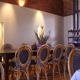

In [ ]:
img

In [ ]:
image = tf.io.decode_image('/content/img.jpg')

In [ ]:
test_image = test_image.

(480, 640, 3)

In [ ]:
# Visualize all the layer outputs of the inception resnet with one image
layer_outputs = [layer.output for layer in inc_resnet.layers] 
activation_model = keras.models.Model(inputs=inc_resnet.input, outputs=layer_outputs)
test_img = np.array(img) # load oneo image from the train set
if device_name == '/device:GPU:0':
  with tf.device('/device:GPU:0'):
    activations = activation_model.predict(tf.convert_to_tensor([test_img])) 
else:
  with tf.device('/device:CPU:0'):
    print('No GPU found')
    exit()

In [ ]:
len(inc_resnet.layers)

780

In [ ]:
inc_resnet.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 39, 39, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 39, 39, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 39, 39, 32)   0           ['batch_normali

In [ ]:
activations[-1]

In [ ]:
# plot all the activations
layer_names = []
for layer in inc_resnet.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    # choose until which layer you want to take

ValueError: ignored